In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
import pandas as pd
import numpy as np


from keras import backend as K

# for the architecture
from keras.models import Sequential
from keras.layers import Dense, Dropout, Lambda, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPool2D, AvgPool2D

# optimizer, data generator and learning rate reductor
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

from keras.optimizers import SGD

Using TensorFlow backend.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
emotion_data = pd.read_csv('/content/drive/My Drive/ER_training/fer2013.csv')
print(emotion_data)

       emotion                                             pixels        Usage
0            0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...     Training
1            0  151 150 147 155 148 133 111 140 170 174 182 15...     Training
2            2  231 212 156 164 174 138 161 173 182 200 106 38...     Training
3            4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...     Training
4            6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...     Training
...        ...                                                ...          ...
35882        6  50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...  PrivateTest
35883        3  178 174 172 173 181 188 191 194 196 199 200 20...  PrivateTest
35884        0  17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...  PrivateTest
35885        3  30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...  PrivateTest
35886        2  19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...  PrivateTest

[35887 rows x 3 columns]


In [33]:
emotion_data.Usage.value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [34]:
#check target labels
emotion_map = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
emotion_counts = emotion_data['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
emotion_counts

,emotion,number
0,Angry,4953
1,Digust,547
2,Fear,5121
3,Happy,8989
4,Sad,6077
5,Surprise,4002
6,Neutral,6198


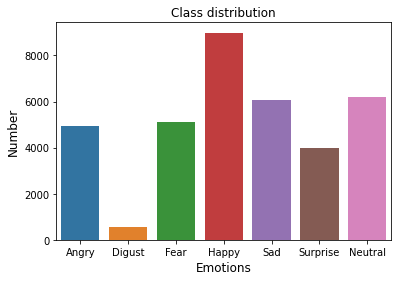

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
sns.barplot(emotion_counts.emotion, emotion_counts.number)
plt.title('Class distribution')
plt.ylabel('Number', fontsize=12)
plt.xlabel('Emotions', fontsize=12)
plt.show()

In [37]:
X_train = []
y_train = []
X_val = []
y_val = []
X_test = []
y_test = []
for index, row in emotion_data.iterrows():
    k = row['pixels'].split(" ")
    if row['Usage'] == 'Training':
      X_train.append(np.array(k))
      y_train.append(row['emotion'])
    elif row['Usage'] == 'PublicTest':
      X_val.append(np.array(k))
      y_val.append(row['emotion'])
    elif row['Usage'] == 'PrivateTest':
      X_test.append(np.array(k))
      y_test.append(row['emotion'])

In [39]:
from keras.utils import np_utils
X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)
X_test = np.array(X_test)
y_test = np.array(y_test)

X_train = X_train.reshape(X_train.shape[0], 48, 48, 1)
X_val = X_val.reshape(X_val.shape[0], 48, 48, 1)
X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)

X_train = X_train.astype('float')
X_val = X_val.astype('float')
X_test = X_test.astype('float')

y_train= np_utils.to_categorical(y_train, num_classes=7)
y_val = np_utils.to_categorical(y_val, num_classes=7)
y_test = np_utils.to_categorical(y_test, num_classes=7)

In [40]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((28709, 48, 48, 1),
 (28709, 7),
 (3589, 48, 48, 1),
 (3589, 7),
 (3589, 48, 48, 1),
 (3589, 7))

y =  [0. 0. 1. 0. 0. 0. 0.]


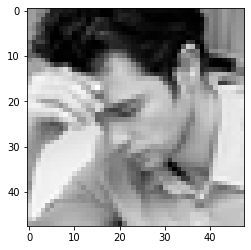

In [41]:
import matplotlib.pyplot as plt

index = 200
plt.imshow(X_train.reshape(28709,48,48)[index], cmap = 'gray')
print('y = ',str(np.squeeze(y_train[index])))
#EMOTIONS = ["angry" ,"disgust","scared", "happy", "sad", "surprised","neutral"]

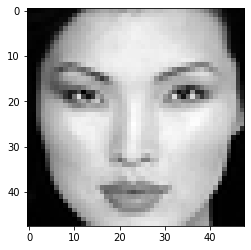

In [42]:
index = 60
plt.imshow(X_val.reshape(3589,48,48)[index], cmap = 'gray')

In [44]:
from keras import regularizers
model = Sequential()

dim = 48
nclasses = 7

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', input_shape=(dim,dim,1)))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))


model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu',))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu',))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
#model.add(Dense(4096, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
#model.add(Dense(2048, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(nclasses, activation='softmax'))


In [45]:
model.summary

<bound method Network.summary of <keras.engine.sequential.Sequential object at 0x7f2a3f884860>>

In [46]:
model.compile(optimizer='sgd',loss='categorical_crossentropy',metrics=['accuracy'])

In [20]:
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                 patience=3, 
                                 verbose=1, 
                                 factor=0.5, 
                                 min_lr=0.00001)

In [48]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', patience = 10, mode = 'min', restore_best_weights=True)

In [49]:
datagen = ImageDataGenerator(
          featurewise_center=False,            # set input mean to 0 over the dataset
          samplewise_center=False,             # set each sample mean to 0
          featurewise_std_normalization=False, # divide inputs by std of the dataset
          samplewise_std_normalization=False,  # divide each input by its std
          zca_whitening=False,                 # apply ZCA whitening
          rotation_range=10,                   # randomly rotate images in the range (degrees, 0 to 180)
          zoom_range = 0.1,                    # Randomly zoom image 
          width_shift_range=0.1,               # randomly shift images horizontally (fraction of total width)
          height_shift_range=0.1,              # randomly shift images vertically (fraction of total height)
          horizontal_flip=False,               # randomly flip images
          vertical_flip=False)                 # randomly flip images

datagen.fit(X_train)

In [50]:
epochs = 20
batch_size = 32

In [51]:
#history = model.fit(X_train, y_train,batch_size= batch_size,epochs= epochs, verbose=1, callbacks = [es], validation_data = (X_test, y_test))
history = model.fit_generator(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs=epochs, 
                              validation_data=(X_val,y_val),
                              verbose=1, 
                              steps_per_epoch=X_train.shape[0] // batch_size, 
                              callbacks=[es])

Epoch 1/20
897/897 [==============================] - 30s 33ms/step - loss: 24.4959 - accuracy: 0.2913 - val_loss: 20.5458 - val_accuracy: 0.3377
Epoch 2/20
897/897 [==============================] - 28s 32ms/step - loss: 17.4605 - accuracy: 0.3868 - val_loss: 14.8315 - val_accuracy: 0.4043
Epoch 3/20
897/897 [==============================] - 28s 32ms/step - loss: 12.5517 - accuracy: 0.4503 - val_loss: 10.6706 - val_accuracy: 0.4578
Epoch 4/20
897/897 [==============================] - 28s 32ms/step - loss: 9.1125 - accuracy: 0.5033 - val_loss: 7.8654 - val_accuracy: 0.4689
Epoch 5/20
897/897 [==============================] - 28s 32ms/step - loss: 6.7064 - accuracy: 0.5365 - val_loss: 5.8285 - val_accuracy: 0.5327
Epoch 6/20
897/897 [==============================] - 28s 32ms/step - loss: 5.0310 - accuracy: 0.5564 - val_loss: 4.4064 - val_accuracy: 0.5542
Epoch 7/20
897/897 [==============================] - 28s 31ms/step - loss: 3.8504 - accuracy: 0.5766 - val_loss: 3.4732 - val_acc

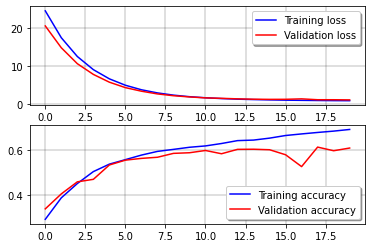

In [52]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss",axes =ax[0])
ax[0].grid(color='black', linestyle='-', linewidth=0.25)
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax[1].grid(color='black', linestyle='-', linewidth=0.25)
legend = ax[1].legend(loc='best', shadow=True)

In [55]:
from sklearn.metrics import accuracy_score
test_true = np.argmax(y_test, axis=1)
test_pred = np.argmax(model.predict(X_test), axis=1)
print("CNN Model Accuracy on test set: {:.4f}".format(accuracy_score(test_true, test_pred)))

CNN Model Accuracy on test set: 0.6202


In [56]:
model_json = model.to_json()
with open("/content/drive/My Drive/ER_training/model.json", "w") as json_file:
  json_file.write(model_json)
  model.save_weights("/content/drive/My Drive/ER_training/model.h5")
print("Saved model to disk")

Saved model to disk
